# 06.03 - PCA, NMF IN PRACTICE

In [12]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Reducción de dimensionalidad para tareas de clasificación

In [14]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
d=mnist[:,1:785] #mnist es un dataset de clasificación para aprendizaje supervisado
c=mnist[:,0]
print ("dimension de las imagenes y las clases", d.shape, c.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)


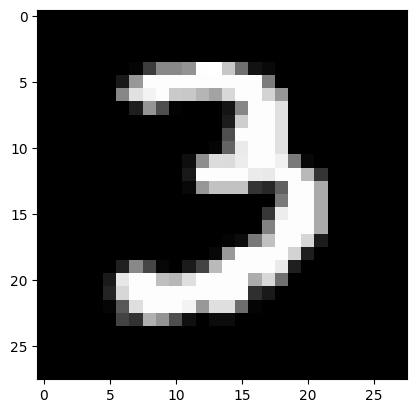

In [15]:
plt.imshow(d[9].reshape(28,28), cmap=plt.cm.gray)


In [16]:
pd.Series(c).value_counts()

2    186
1    157
7    154
6    152
4    151
0    150
9    146
8    141
5    138
3    125
dtype: int64

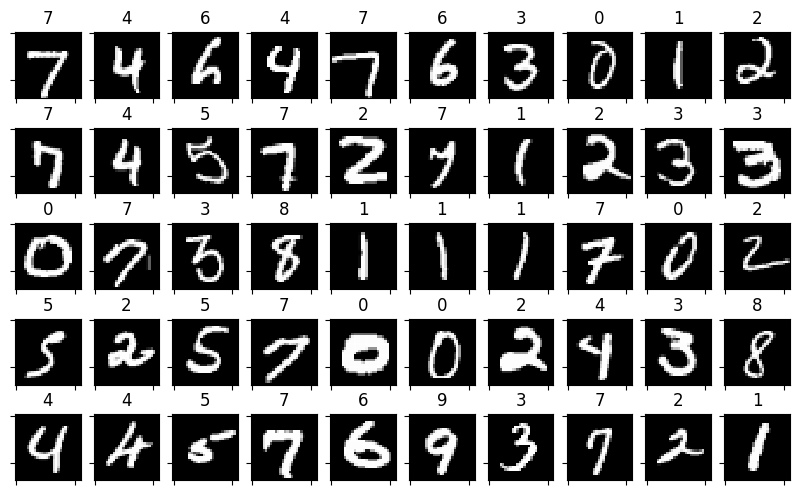

In [17]:
perm = np.random.permutation(range(d.shape[0]))[0:50]
random_imgs   = d[perm]
random_labels = c[perm] 
fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

## Principal Component Analysis

In [18]:
from sklearn.decomposition import PCA

mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]
y=mnist[:,0]



In [10]:
X.shape

(1500, 784)

In [11]:
for i in np.unique(y):
    print (i, np.sum(y==i))

0 150
1 157
2 186
3 125
4 151
5 138
6 152
7 154
8 141
9 146


In [19]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=.3)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((1050, 784), (450, 784), (1050,), (450,))

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
dt = GaussianNB()
dt.fit(Xtr, ytr)
dt.score(Xtr, ytr), dt.score(Xts, yts)

(0.6904761904761905, 0.5955555555555555)

In [21]:
#Dependiendo del numero de componentes puede funcionar mejor o peor
pca = PCA(n_components=10) #Reducción de 784 a 10 componentes
Xp = pca.fit_transform(X)#Hace el fit y el transform de una vez

Xptr, Xpts, yptr, ypts = train_test_split(Xp,y,test_size=.3)
Xptr.shape, Xpts.shape, yptr.shape, ypts.shape
dt.fit(Xptr, yptr)
dt.score(Xptr, yptr), dt.score(Xpts, ypts)

(0.7819047619047619, 0.7111111111111111)

In [22]:
cs = range(10,200,5)

In [23]:
dtr, dts = [], []
for n_components in cs:
    print (".", end="")
    pca = PCA(n_components=n_components)
    pca.fit(Xtr)

    Xt_tr = pca.transform(Xtr)
    Xt_ts = pca.transform(Xts)

    dt.fit(Xt_tr,ytr)
    ypreds_tr = dt.predict(Xt_tr)
    ypreds_ts = dt.predict(Xt_ts)
    ypreds_tr.shape, ypreds_ts.shape
    dtr.append(np.mean(ytr==ypreds_tr))#Promedios de acierto en train
    dts.append(np.mean(yts==ypreds_ts))#Promedios de acierto en test


......................................

In [24]:
len(dtr), len(dts)

(38, 38)

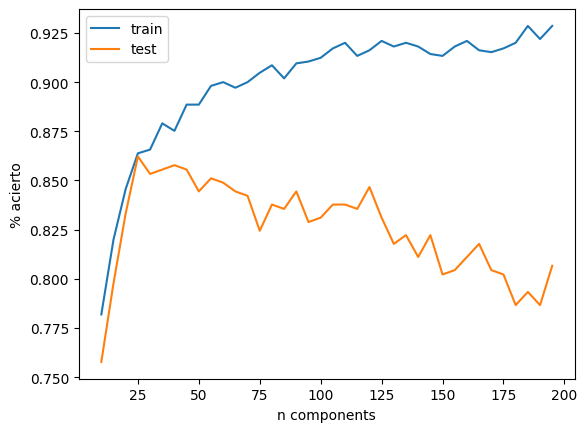

In [25]:
plt.plot(cs, dtr, label="train")
plt.plot(cs, dts, label="test")
plt.xlabel("n components")
plt.ylabel("% acierto")
plt.legend()

In [26]:
best_cs = cs[np.argmax(dts)]
best_cs #Numero de componentes que dio mejor resultado

25

### clasificación en el nuevo espacio de representación

In [27]:
pca = PCA(n_components=best_cs)
pca.fit(Xtr)

Xt_tr = pca.transform(Xtr)
Xt_ts = pca.transform(Xts)
dt.fit(Xt_tr,ytr)
ypreds_tr = dt.predict(Xt_tr)
ypreds_ts = dt.predict(Xt_ts)
ypreds_tr.shape, ypreds_ts.shape
np.mean(ytr==ypreds_tr),np.mean(yts==ypreds_ts)

(0.8638095238095238, 0.8644444444444445)

### pipelines

debemos de tener cuidado cuando usamos transformaciones en clasificación, ya que tenemos que ajustarlas (de manera no supervisada) sólo con los datos de entrenamiento

Pipeline pasa primero el pca y luego el estimador


In [28]:
from sklearn.pipeline import Pipeline

estimator = Pipeline((("pca", PCA(n_components=best_cs)), ("naive", dt)))
estimator.fit(Xtr, ytr)
estimator.score(Xtr, ytr), estimator.score(Xts, yts)

(0.8628571428571429, 0.8644444444444445)

In [29]:
from sklearn.model_selection import cross_val_score
pip = Pipeline([("PCA", PCA(n_components=best_cs)), ("gaussian", GaussianNB())])
scores = cross_val_score(pip, X,y, cv=5 )
print ("%.2f +/- %.4f"%(np.mean(scores), np.std(scores)))

0.84 +/- 0.0150


Viendo las tripas del PCA

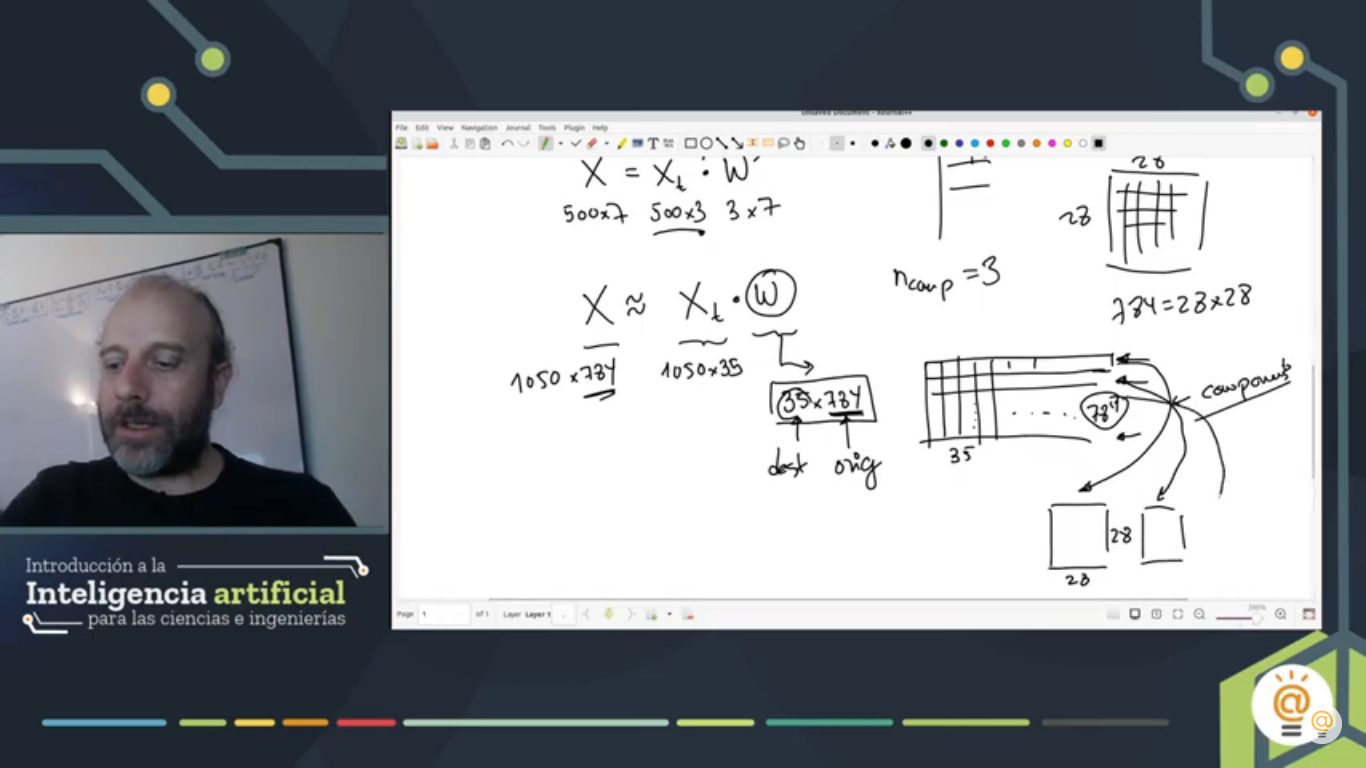

In [30]:
pca.components_.shape

(25, 784)

### obtenemos los componentes principales

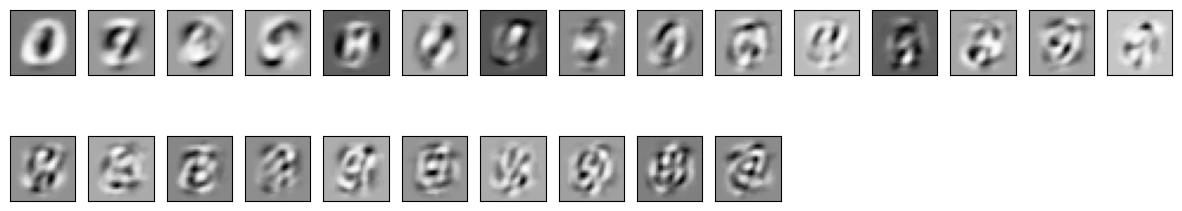

In [31]:
cols=20
plt.figure(figsize=(15,3))
for i in range(len(pca.components_)):
    plt.subplot(int(np.ceil(len(pca.components_)/15)),15,i+1)
    plt.imshow((pca.components_[i].reshape(28,28)), cmap = plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

### verificamos la reconstrucción con los componentes principales

In [32]:
pca = PCA(n_components=best_cs)
pca.fit(Xtr)
Xp = pca.transform(X)

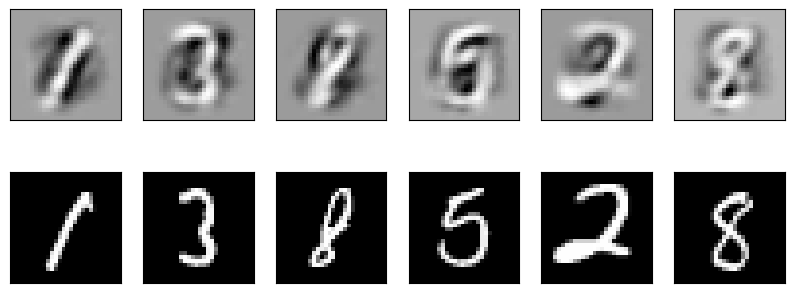

In [33]:
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(3,6,i+1)
    k = np.random.randint(len(X))
    plt.imshow((np.sum((pca.components_*Xp[k].reshape(-1,1)), axis=0)).reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])
    plt.subplot(3,6,6+i+1)
    plt.imshow(X[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

### observa la nueva representación de la primera imagen

In [34]:
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0, 188, 255,  94,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0, 191, 250, 253,  93,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

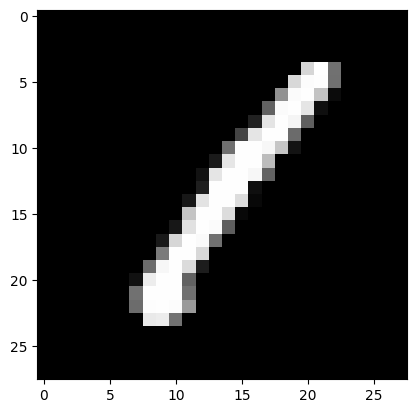

In [35]:
plt.imshow(X[0].reshape(28,28), cmap = plt.cm.Greys_r)

In [36]:
Xp[0]

array([-600.66171032,  767.41368984,  197.75495754, -145.94849383,
       -231.36775941, -406.62060266,  -63.57955417,  616.71002508,
        329.72547943,  -83.98500907, -345.14735406,  -69.40974813,
       -188.53691614,  342.8677133 ,  209.31464564,  -11.14920499,
        229.23916678, -318.81101143,  174.20256903,  -87.92978168,
        -61.80140928,  299.4978465 ,  -33.47644754,   89.67240572,
         30.94870954])

which correspond to the same components above for PCA.

## Non negative matrix factorization

Descomponemos una matriz $V \in \mathbb{R}_+^{m\times n}$ en el producto $W \times H$, con $W \in \mathbb{R}_+^{m\times r}$ y $H \in \mathbb{R}_+^{r\times n}$ con la restricción de que todo sea positivo ($\in \mathbb{R}_+$), de forma que:

$$V \approx W \times H$$

Las filas de $H$ son los _componentes base_, y se soluciona planteándolo como un problema de optimización matemática con restricciones.

$$\begin{split}
argmin_{W,H}\;& ||V-W\times H||\\
s.t.&\;W,H \in \mathbb{R}_+
\end{split}$$

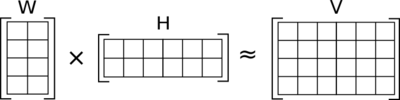

In [37]:
from IPython.display import Image
Image(filename='local/imgs/nmf.png')

### obtenemos la descomposición

In [38]:
from sklearn.decomposition import NMF
X=mnist[:,1:785]; y=mnist[:,0]

nmf = NMF(n_components=15, init="random")
Xn  = nmf.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


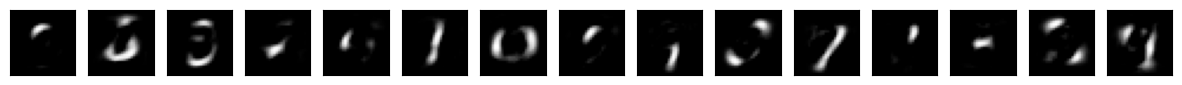

In [39]:
cols=20
plt.figure(figsize=(15,3))
for i in range(len(nmf.components_)):
    plt.subplot(int(len(nmf.components_)/15),15,i+1)
    plt.imshow(np.abs(nmf.components_[i].reshape(28,28)), cmap = plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

In [40]:
Xn[0,:]

array([ 0.        ,  0.        ,  0.        ,  3.10004653,  0.        ,
        1.34763766,  0.        ,  0.        ,  0.        ,  3.46395972,
        0.        , 11.08835435,  1.38807291,  0.19908502,  0.        ])

### verfiicamos la reconstrucción

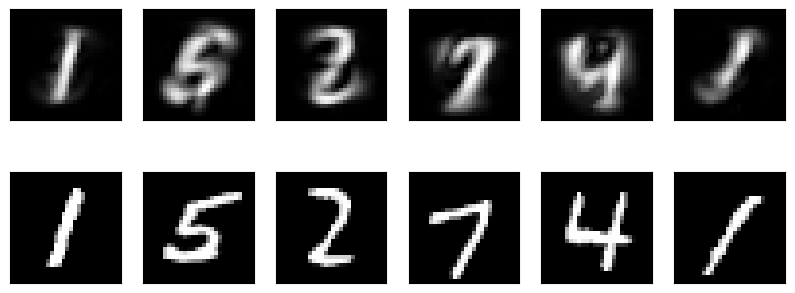

In [41]:
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(3,6,i+1)
    k = np.random.randint(len(X))
    plt.imshow(np.abs(np.sum((nmf.components_*Xn[k].reshape(-1,1)), axis=0)).reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])
    plt.subplot(3,6,6+i+1)
    plt.imshow(X[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

### clasificamos en el nuevo espacio de representación

In [42]:
print (np.mean(cross_val_score(GaussianNB(), X,y, cv=5 )))
print (np.mean(cross_val_score(GaussianNB(), Xn,y, cv=5 )))

0.5953333333333334
0.7633333333333334


### la primera imagen en el nuevo espacio de representación
observa que todos los componentes son positivos

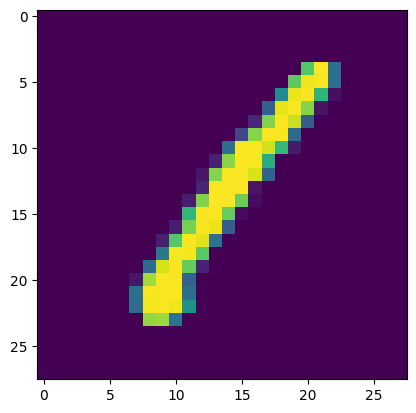

In [43]:
plt.imshow(X[0].reshape(28,28))

In [44]:
Xn[0]

array([ 0.        ,  0.        ,  0.        ,  3.10004653,  0.        ,
        1.34763766,  0.        ,  0.        ,  0.        ,  3.46395972,
        0.        , 11.08835435,  1.38807291,  0.19908502,  0.        ])

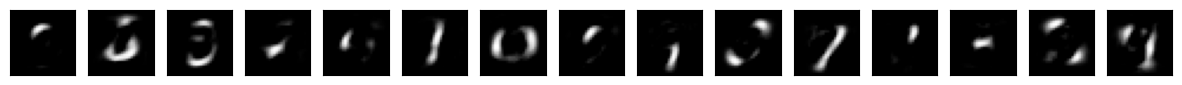

In [45]:
cols=20
plt.figure(figsize=(15,3))
for i in range(len(nmf.components_)):
    plt.subplot(int(len(nmf.components_)/15),15,i+1)
    plt.imshow(np.abs(nmf.components_[i].reshape(28,28)), cmap = plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

## NMF para el reconocimiento de rostros

Dos partes: Detección de rostros e identificación de rostros en un dataset

In [46]:
import numpy as np
faces = np.load("local/data/faces.npy") #Faces es un dataset publico

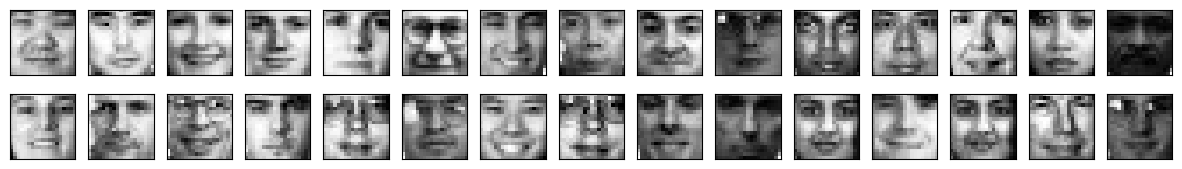

In [47]:
plt.figure(figsize=(15,2))
for i in range(30):
    plt.subplot(2,15,i+1)
    plt.imshow(faces[np.random.randint(len(faces))].reshape(19,19), cmap=plt.cm.Greys_r) 
    plt.xticks([]); plt.yticks([])

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


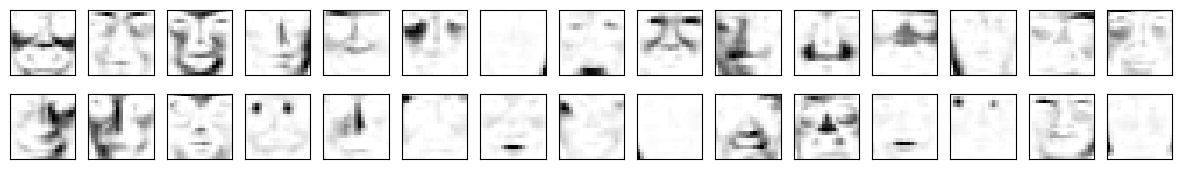

In [48]:
nmf      = NMF(n_components=30, init="random")
faces_n  = nmf.fit_transform(faces)
cols=20
plt.figure(figsize=(15,2))
for i in range(len(nmf.components_)):
    plt.subplot(int(np.ceil(len(nmf.components_)/15.)),15,i+1)
    plt.imshow(np.abs(nmf.components_[i].reshape(19,19)), cmap = plt.cm.Greys)
    plt.xticks([]); plt.yticks([])

forzamos dispersión en los componentes, y extendemos el problema de optimización con la norma $L_1$ en los componentes base.

$$\begin{split}
argmin_{W,H}\;& ||V-W\times H|| + ||H||^2_1\\
s.t.&\;W,H \in \mathbb{R}_+
\end{split}$$

también podríamos forzar dispersión en la nueva representación
$$\begin{split}
argmin_{W,H}\;& ||V-W\times H|| + ||W||^2_1\\
s.t.&\;W,H \in \mathbb{R}_+
\end{split}$$


In [54]:
nmf      = NMF(n_components=30, init="nndsvd", alpha=1000, l1_ratio=1)
faces_n  = nmf.fit_transform(faces)
cols=20
plt.figure(figsize=(15,2))
print (np.sum(nmf.components_))
for i in range(len(nmf.components_)):
    plt.subplot(np.ceil(len(nmf.components_)/15.),15,i+1)
    plt.imshow(np.abs(nmf.components_[i].reshape(19,19)), cmap = plt.cm.Greys)
    plt.xticks([]); plt.yticks([])

TypeError: ignored